In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [2]:
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

# path for dataset (will be not there after end of session)
path_data = "./data"
path_logs = "./logs"

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Dataloaders

In [5]:
BATCH_SIZE = 32
augment = False
random_seed = 1

train_loader, valid_loader = get_train_valid_loader(path_data,
                           BATCH_SIZE,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True)

dataloaders = {"train": train_loader, 
               "val": valid_loader}

test_loader = get_test_loader(path_data,
                    BATCH_SIZE,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### VGG-16

In [6]:
model = models.vgg16(pretrained=False)
model.classifier = nn.Linear(25088, 10)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
best_model, val_acc_history, plot_df = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25)

Epoch 0/24 	Train loss: 1.8948 acc: 0.2819 		 Val loss: 1.5383 acc: 0.4168
Epoch 1/24 	Train loss: 1.3446 acc: 0.5064 		 Val loss: 1.2530 acc: 0.5402
Epoch 2/24 	Train loss: 1.0770 acc: 0.6128 		 Val loss: 0.9874 acc: 0.6526
Epoch 3/24 	Train loss: 0.8794 acc: 0.6871 		 Val loss: 0.8559 acc: 0.6972
Epoch 4/24 	Train loss: 0.7423 acc: 0.7383 		 Val loss: 0.7711 acc: 0.7238
Epoch 5/24 	Train loss: 0.6262 acc: 0.7764 		 Val loss: 0.7319 acc: 0.7406
Epoch 6/24 	Train loss: 0.5244 acc: 0.8168 		 Val loss: 0.7297 acc: 0.7540
Epoch 7/24 	Train loss: 0.4321 acc: 0.8496 		 Val loss: 0.7551 acc: 0.7454
Epoch 8/24 	Train loss: 0.3551 acc: 0.8741 		 Val loss: 0.7445 acc: 0.7664
Epoch 9/24 	Train loss: 0.2853 acc: 0.8992 		 Val loss: 0.7482 acc: 0.7692
Epoch 10/24 	Train loss: 0.2253 acc: 0.9206 		 Val loss: 0.9279 acc: 0.7454
Epoch 11/24 	Train loss: 0.1815 acc: 0.9361 		 Val loss: 0.8143 acc: 0.7742
Epoch 12/24 	Train loss: 0.1399 acc: 0.9508 		 Val loss: 0.8813 acc: 0.7784
Epoch 13/24 	Train los

In [10]:
val_acc_history.head(3).append(val_acc_history.tail(3))

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.894846,0.281911,1.538253,0.4168
1,1,1.344615,0.506356,1.253017,0.5402
2,2,1.077023,0.612844,0.987416,0.6526
22,22,0.036666,0.986733,1.095898,0.7888
23,23,0.033735,0.987978,1.190778,0.7778
24,24,0.030270,0.989911,1.238559,0.7764


In [11]:
val_acc_history.to_csv(path_logs+"/EXP08.csv", index=None)

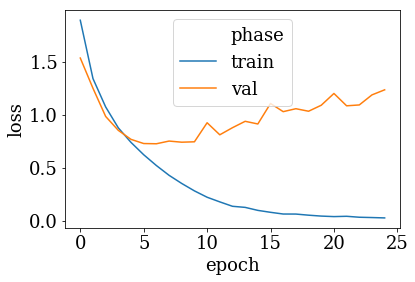

In [12]:
s = sns.lineplot(x='epoch', y='loss', data=plot_df, hue='phase')

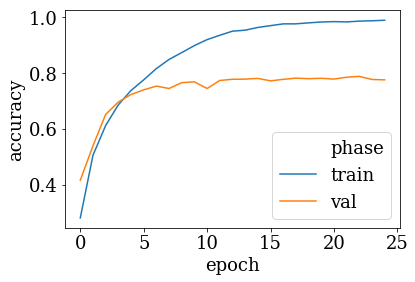

In [13]:
s = sns.lineplot(x='epoch', y='accuracy', data=plot_df, hue='phase')

In [14]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Accuracy of the network on the 10000 test images: 78.59 %


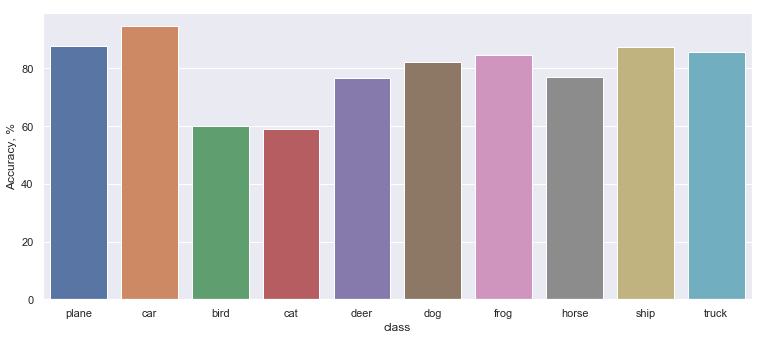

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels.to('cuda')).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.to('cuda') == labels.to('cuda')).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
acc_res_num = 100*np.array(class_correct) / np.array(class_total)
acc_res_df = pd.DataFrame({"class": classes, "Accuracy, %": acc_res_num})
sns.set(rc={'figure.figsize':(12.7,5.27)})
s = sns.barplot(x='class', y='Accuracy, %', data=acc_res_df)

In [16]:
acc_res = [str(round(v, 2))+"%" for v in acc_res_num]
acc_res_df_per = pd.DataFrame({"class": classes, "Accuracy, %": acc_res})
acc_res_df_per

,class,"Accuracy, %"
0,plane,87.79%
1,car,94.53%
2,bird,60.0%
3,cat,58.99%
4,deer,76.7%
5,dog,82.26%
6,frog,84.56%
7,horse,76.92%
8,ship,87.29%
9,truck,85.83%
